In [4]:
!pip install torchaudio lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.

In [5]:
import librosa
import numpy as np
import torch

def extract_features(path, sr=12000, duration=1.0, augment=False):
    y, _ = librosa.load(path, sr=sr, mono=True, duration=duration)
    
    if augment:
        if np.random.rand() < 0.3:
            y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.choice([-2, -1, 1, 2]))
        if np.random.rand() < 0.3:
            y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.9, 1.1))
        if np.random.rand() < 0.3:
            y += 0.005 * np.random.randn(len(y))  # noise

    # Pad
    target_length = int(sr * duration)
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)), 'constant')
    else:
        y = y[:target_length]

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc_mean = np.mean(mfccs, axis=1)
    mfcc_std = np.std(mfccs, axis=1)

    # ZCR
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    zcr_mean = np.mean(zcr)
    zcr_std = np.std(zcr)

    # Log Spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=40)
    log_S = librosa.power_to_db(S)
    spec_mean = np.mean(log_S, axis=1)
    spec_std = np.std(log_S, axis=1)

    return np.concatenate([mfcc_mean, mfcc_std, [zcr_mean, zcr_std], spec_mean, spec_std])


In [6]:
from sklearn.preprocessing import LabelEncoder
import os

def load_dataset(folder, augment=False):
    X, y = [], []
    for fname in os.listdir(folder):
        if fname.endswith(".wav"):
            label = fname.split("_")[0]
            path = os.path.join(folder, fname)
            try:
                feats = extract_features(path, augment=augment)
                X.append(feats)
                y.append(label)
            except:
                continue
    le = LabelEncoder()
    y = le.fit_transform(y)
    return np.array(X), y, le


In [7]:
train_folder = "/kaggle/input/stage2/data/train"
test_folder = "/kaggle/input/stage2/data/test"

In [8]:
X_train, y_train, le = load_dataset(train_folder, augment=True)
X_test, y_test, _ = load_dataset(test_folder, augment=False)


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


In [9]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
    n_estimators=50,
    class_weight='balanced',
    max_depth=10,
    random_state=42
)
clf.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31110
[LightGBM] [Info] Number of data points in the train set: 5628, number of used features: 122
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


LGBMClassifier(class_weight='balanced', max_depth=10, n_estimators=50,
               random_state=42)

In [11]:
pip install codecarbon --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 6.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 4.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.21.1 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.
firebase-admin 6.9.0 requires httpx[http2]==0.28.1, but you have httpx 0.27.2 which is incompatible.
langchain-core 0.3.66 requires packaging<25,>=23.2, but you have packaging 25.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [14]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import time
from codecarbon import EmissionsTracker

# Predictions
# === Track Energy + Time ===
tracker = EmissionsTracker(project_name="LGBM")
tracker.start()
start_time = time.time()

y_pred = clf.predict(X_test)

train_time = time.time() - start_time
emissions = tracker.stop()

print(f"\n🔧 Training Time: {train_time*1000:.2f} m.seconds")
print(f"🔋 Energy Emissions: {emissions*1000000:.6f} mg CO₂\n")

print(classification_report(y_test, y_pred, target_names=le.classes_))


[codecarbon WARNING @ 16:42:35] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 16:42:35] [setup] RAM Tracking...
[codecarbon INFO @ 16:42:35] [setup] CPU Tracking...
[codecarbon WARNING @ 16:42:37] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 16:42:37] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 16:42:37] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 16:42:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:42:37] [setup] GPU Tracking...
[codecarbon INFO @ 16:42:37] No GPU found.
[codecarbon INFO @ 16:42:37] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               


🔧 Training Time: 18.77 m.seconds
🔋 Energy Emissions: 0.051402 mg CO₂

                 precision    recall  f1-score   support

backgroundnoise       0.53      0.79      0.63       402
 brokenbranches       0.80      0.74      0.77       402
      footsteps       0.85      0.77      0.81       402
        gunshot       0.85      0.58      0.69       402

       accuracy                           0.72      1608
      macro avg       0.76      0.72      0.72      1608
   weighted avg       0.76      0.72      0.72      1608



In [15]:
# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
y_score = clf.predict_proba(X_test)  # shape: [n_samples, n_classes]

# AUC scores
auc_scores = roc_auc_score(y_test_bin, y_score, average=None)

for i, class_name in enumerate(le.classes_):
    print(f"AUC for class {class_name}: {auc_scores[i]:.4f}")

macro_auc = roc_auc_score(y_test_bin, y_score, average="macro")
print(f"Macro-average AUC: {macro_auc:.4f}")


AUC for class backgroundnoise: 0.8573
AUC for class brokenbranches: 0.9269
AUC for class footsteps: 0.9227
AUC for class gunshot: 0.8759
Macro-average AUC: 0.8957


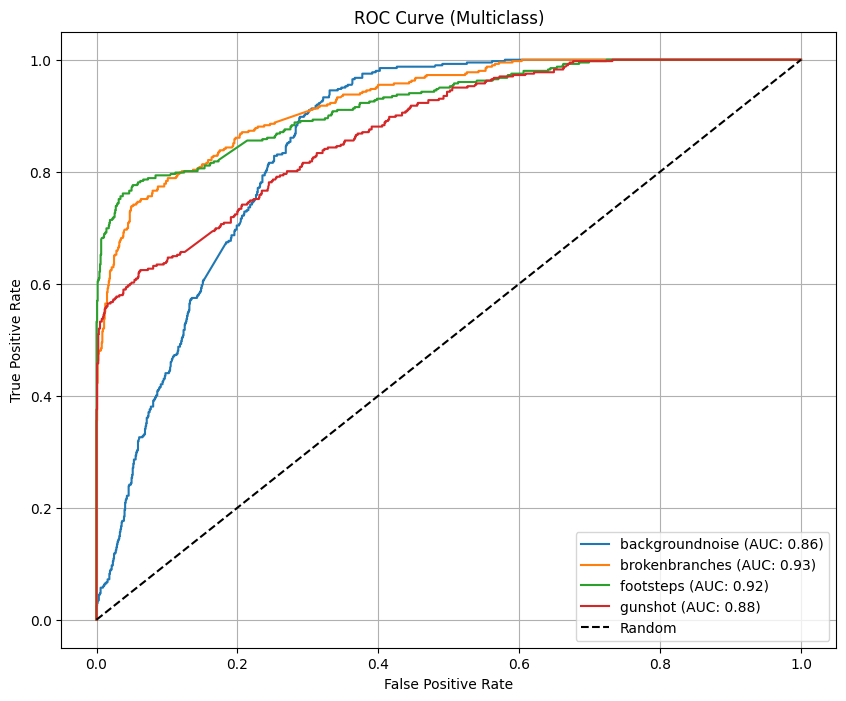

In [16]:
plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC: {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multiclass)')
plt.legend()
plt.grid(True)
plt.show()
